In [15]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [30]:
import json

In [6]:
import nltk
from nltk.tokenize import word_tokenize

In [17]:
path = "./dataset/"
df = pd.read_csv(path + "df_completo.csv")

Divide el conjunto de datos en entrenamiento, validación y prueba

In [18]:
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)
val_df = train_df.sample(frac=0.2, random_state=42)
train_df = train_df.drop(val_df.index)

In [5]:
print("Test: ", test_df.shape)
print("Validation: ", val_df.shape)
print("Train: ", train_df.shape)
print("Total: ", test_df.shape[0] + val_df.shape[0] + train_df.shape[0])

Test:  (8978, 12)
Validation:  (7182, 12)
Train:  (28728, 12)
Total:  44888


In [7]:
average_tokens = df['text'].apply(lambda text: len(word_tokenize(text))).mean()

print(f'Promedio de tokens: {average_tokens}')

Promedio de tokens: 453.54424345036534


In [8]:
handle_encoder = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
}

In [9]:
handle_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

In [10]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

bert_encoder = handle_encoder[bert_model_name]
bert_preprocess = handle_preprocess[bert_model_name]

print(f'BERT model selected           : {bert_encoder}')
print(f'Preprocess model auto-selected: {bert_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [11]:
bert_preprocess_model = hub.KerasLayer(bert_preprocess)

In [12]:
ejemplo = df['text'][0]
print(ejemplo[:300])
text_test = [ejemplo]
text_preprocessed = bert_preprocess_model(text_test)

Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger a


In [13]:
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 6221 8398 2074 2481 1056 4299 2035 4841 1037 3407 2047]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [14]:
bert_model = hub.KerasLayer(bert_encoder)

In [15]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {bert_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[-0.38383743  0.99906754 -0.33345526  0.24275582  0.00548695 -0.8419128
  0.9907584  -0.9580104  -0.5244734  -0.9812168  -0.4539475  -0.45915237]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.03366964 -0.5598196   0.8219307  ... -0.7387405   0.36061755
   0.5865588 ]
 [ 0.8805909   0.7951543  -0.3251872  ... -1.6401056  -0.17664099
   0.61988837]
 [-0.22252081  0.30826443  0.8413201  ... -0.5016649   1.4924184
  -0.93998665]
 ...
 [-0.5809002  -0.4837727  -0.06616035 ... -0.45230436 -0.98680437
   0.94981784]
 [-0.11579455 -1.6830171   1.1207352  ... -1.0249656  -0.4304437
   0.88629407]
 [-0.10072567 -0.23767962  0.38406843 ...  0.6513421  -0.8575418
  -0.46584442]]


In [19]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32, fraction=1.0):
    if fraction < 1.0:
        dataframe = dataframe.sample(frac=fraction, random_state=42)
    print(f"Número de ejemplares después de aplicar fraction={fraction}: {len(dataframe)}")
    dataframe = dataframe.copy()
    labels = dataframe.pop('label')
    ds = tf.data.Dataset.from_tensor_slices((dataframe['text'].values, labels.values))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [20]:
batch_size = 32
train_ds = df_to_dataset(train_df, batch_size=batch_size, fraction=0.1)
val_ds = df_to_dataset(val_df, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test_df, shuffle=False, batch_size=batch_size)

Número de ejemplares después de aplicar fraction=0.1: 2859
Número de ejemplares después de aplicar fraction=1.0: 7149
Número de ejemplares después de aplicar fraction=1.0: 8936


In [18]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(bert_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(bert_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [19]:
classifier_model = build_classifier_model()

In [31]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

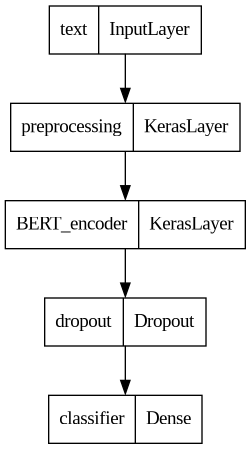

In [20]:
tf.keras.utils.plot_model(classifier_model)

In [21]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

In [22]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [23]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [24]:
print("Entrenando el modelo...")
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Entrenando el modelo...
Epoch 1/5
90/90 [==============================] - 617s 7s/step - loss: 0.9011 - binary_accuracy: 0.8531 - val_loss: 0.0291 - val_binary_accuracy: 0.9972
Epoch 2/5
90/90 [==============================] - 613s 7s/step - loss: 0.0222 - binary_accuracy: 0.9983 - val_loss: 0.0226 - val_binary_accuracy: 0.9979
Epoch 3/5
90/90 [==============================] - 604s 7s/step - loss: 0.0020 - binary_accuracy: 0.9993 - val_loss: 0.0132 - val_binary_accuracy: 0.9990
Epoch 4/5
90/90 [==============================] - 562s 6s/step - loss: 2.0039e-04 - binary_accuracy: 1.0000 - val_loss: 0.0158 - val_binary_accuracy: 0.9989
Epoch 5/5
90/90 [==============================] - 540s 6s/step - loss: 1.4090e-04 - binary_accuracy: 1.0000 - val_loss: 0.0138 - val_binary_accuracy: 0.9989


In [25]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

281/281 [==============================] - 322s 1s/step - loss: 0.0197 - binary_accuracy: 0.9982
Loss: 0.019741427153348923
Accuracy: 0.9982178807258606


In [26]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [27]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

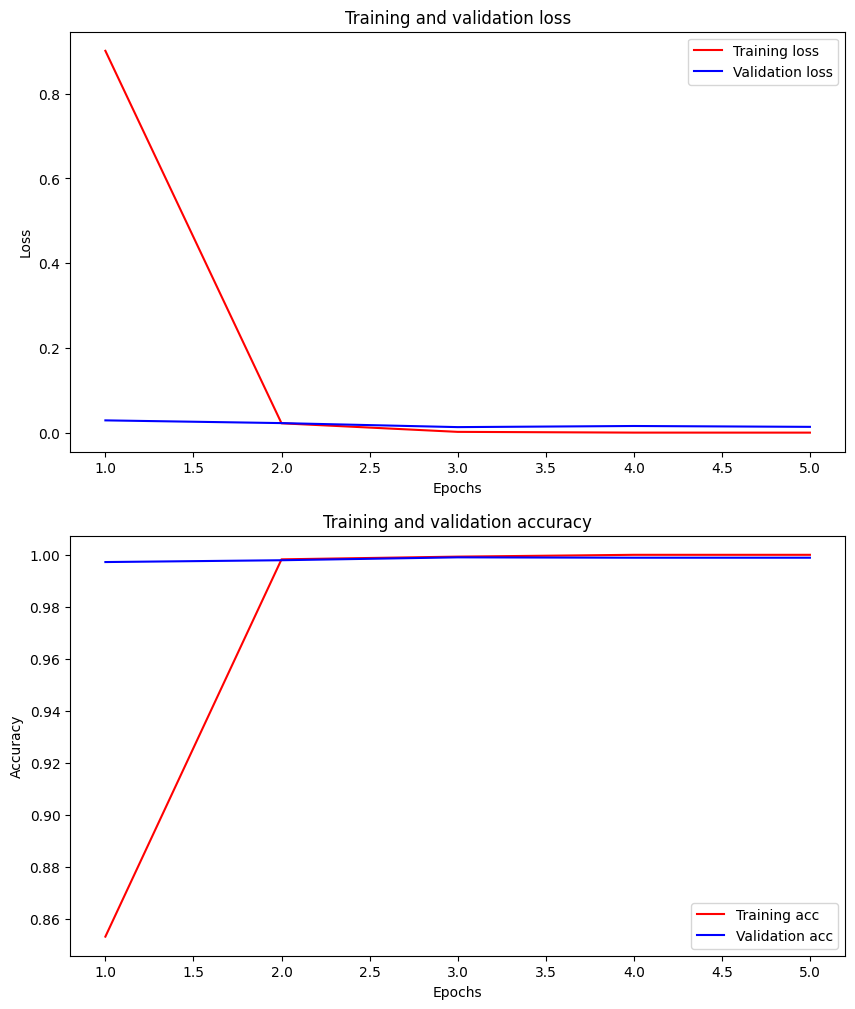

In [46]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 12))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [47]:
classifier_model.save("./modelo_bert/bert.keras")

In [48]:
classifier_model.save_weights("./modelo_bert/bert.h5")

In [50]:
with open('./modelo_bert/bert.json', 'w') as f:
    json.dump(history.history, f)

In [36]:
y_predicted = classifier_model.predict(test_ds)

281/281 [==============================] - 344s 1s/step


In [37]:
y_pred = np.where(y_predicted > 0.5, 1, 0)

In [38]:
y_true = []
for _, labels in test_ds:
    y_true.append(labels)
y_true = np.concatenate(y_true, axis=0)

In [39]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Exactitud del modelo optimizado: {accuracy:.4f}')

Exactitud del modelo optimizado: 0.9982


In [40]:
report = classification_report(y_true, y_pred, target_names=['Negativo', 'Positivo'])
print('Reporte de clasificación del modelo optimizado:')
print(report)

Reporte de clasificación del modelo optimizado:
              precision    recall  f1-score   support

    Negativo       1.00      1.00      1.00      4754
    Positivo       1.00      1.00      1.00      4224

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978



In [41]:
conf_matrix = confusion_matrix(y_true, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

Matriz de Confusión:
[[4745    9]
 [   7 4217]]


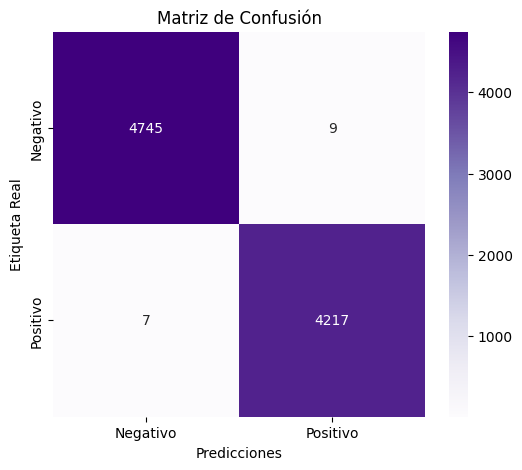

In [51]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()